In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import seaborn as sb
import pandas as pd

from MDAnalysis.analysis import pca as mda_pca
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
from sklearn.decomposition import PCA

%matplotlib inline

import nglview as nv

import warnings
warnings.filterwarnings('ignore')

# Process data using MDAnalysis

In [2]:
u_og =  mda.Universe("first.pdb","og.pdb")
ca_og = u_og.select_atoms("name CA")

assert ca_og.universe.trajectory.frame == 0

n_frames = ca_og.universe.trajectory.n_frames
n_atoms = ca_og.n_atoms
frame_start = 0
frame_end = n_frames

ca_og_pos = np.zeros((n_frames, 3*n_atoms))
ca_og_mean_pos = np.zeros((n_atoms, 3))

for i,_ in enumerate(ca_og.universe.trajectory[frame_start:frame_end:1]):
    tmp = ca_og.positions.flatten()
    ca_og_pos[i,:] = tmp
    ca_og_mean_pos += ca_og.positions

ca_og_mean_pos /= (frame_end - frame_start)

In [3]:
u_mod_rt =  mda.Universe("first.pdb","fit_1_rt.pdb")
ca_rt = u_mod_rt.select_atoms("name CA")

assert ca_rt.universe.trajectory.frame == 0

n_frames = ca_rt.universe.trajectory.n_frames
n_atoms = ca_rt.n_atoms
frame_start = 0
frame_end = n_frames

ca_rt_pos = np.zeros((n_frames, 3*n_atoms))
ca_rt_mean_pos = np.zeros((n_atoms, 3))

for i,_ in enumerate(ca_rt.universe.trajectory[frame_start:frame_end:1]):
    tmp = ca_rt.positions.flatten()
    ca_rt_pos[i,:] = tmp
    ca_rt_mean_pos += ca_rt.positions

ca_rt_mean_pos /= (frame_end - frame_start)

# 1. Perform PCA on original coordinates

In [4]:
def Cov(X):
    """
    Calculate the covariance matrix.
    Each feature is assumed to be in a column of X.
    So we subtract the mean of each column from each observation (each row value).
    X.mean(axis=0) estimates mean of each column of X.
    Then, the formula is
    Cov = A.T @ A / (N-1)
    N-1 is called Bessel's correction.
    Verify the result with numpy's covariance matrix.
    -----------------------------------------
    X: np.ndarray which is 2D.
    """
    
    X_scaled = X - X.mean(axis=0) 
    cov = X_scaled.transpose() @ X_scaled / (X_scaled.shape[0] - 1)

    np_cov = np.cov(X, rowvar = False)

    # Compare to Numpy results
    assert abs(cov - np_cov).all() < 1e-8
    assert np.shape(cov) == np.shape(np_cov)

    return cov


In [5]:
def my_pca(X, num_components = 2):
    """
    Do PCA on X.
    ---------------------
    X: np.ndarray which is 2D.
    num_components: Number of components to project to. Default is set to 2.
    """

    X_scaled = X - X.mean(axis = 0) # center the coordinates
    
    cov_matrix = Cov(X) # compute covariance matrix
    eigvals , eigvecs = np.linalg.eig(cov_matrix) # get eigenvalues and eigenvectors of C

    # Sort the eigenvalues
    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]

    # Sort the eigenvectors
    sorted_eigvecs = eigvecs[:,sorted_index]
    eigvec_reduced_dim = sorted_eigvecs[:,0:num_components]

    # Project data on the reduced dimensional eigenvector space
    X_projected = np.dot(eigvec_reduced_dim.transpose(), X_scaled.transpose()).transpose()
    #X_projected = np.dot(X_scaled, eigvec_reduced_dim)
    #X_projected_full = X_scaled @ sorted_eigvecs

    # Make a plot for eigenvalues
    plt.plot(sorted_eigvals, 'b.')
    plt.title("Sorted Eigenvalues")
    plt.xlabel(r"$\lambda$ number")
    plt.ylabel(r"$\lambda$")
    
    #print(sorted_eigvals)

    return sorted_eigvals, X_projected, sorted_eigvecs

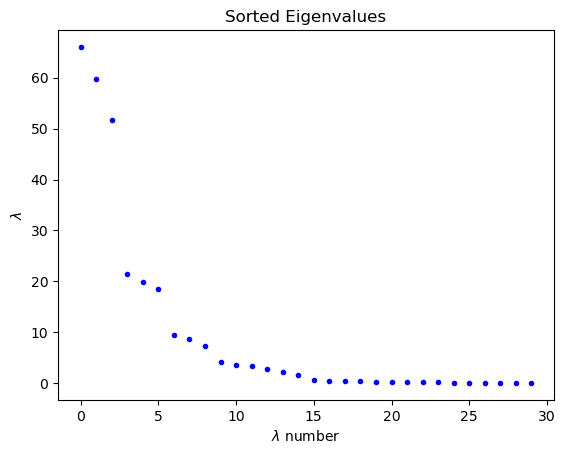

In [6]:
ca_og_eigvals, ca_og_projected, ca_og_eigvecs = my_pca(ca_og_pos,2)

In [7]:
def scree_plot(eigvals, sklearn_PCA):
    """
    Make a plot of the explained variance and individual variance contributions of each eigenvalue.
    Compare the results to sklearn.
    --------------------------------
    eigvals: sorted eigenvalue array
    sklearn_PCA: the sklearn PCA() method that was used to fit the data for verification purposes.
    """

    PC_values_sklearn = np.arange(sklearn_PCA.n_components_) + 1
    
    variance_contributions = eigvals/np.sum(eigvals)

    PC_values = np.arange(variance_contributions.shape[0]) + 1
    plt.title('Scree Plot')
    plt.plot(PC_values_sklearn, sklearn_PCA.explained_variance_ratio_, 'bo-', label='sklearn PCA')
    plt.plot(PC_values, variance_contributions, 'r.', label='My PCA')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.legend()
    plt.show()

    plt.title('Visualize variance change as we add diff PCs')
    plt.ylabel('Explained Variance')
    plt.xlabel('Number of components')
    plt.plot(np.cumsum(sklearn_PCA.explained_variance_ratio_), 'bo-', label='sklearn PCA')
    plt.plot(np.cumsum(variance_contributions), 'r.', label='My PCA')
    plt.legend()
    plt.show()
    
    var_pc_1_2 = variance_contributions[0] + variance_contributions[1]
    print(f"Proportion of variance explained by first 2 PCs = {var_pc_1_2}")

### Compare my results to sklearn

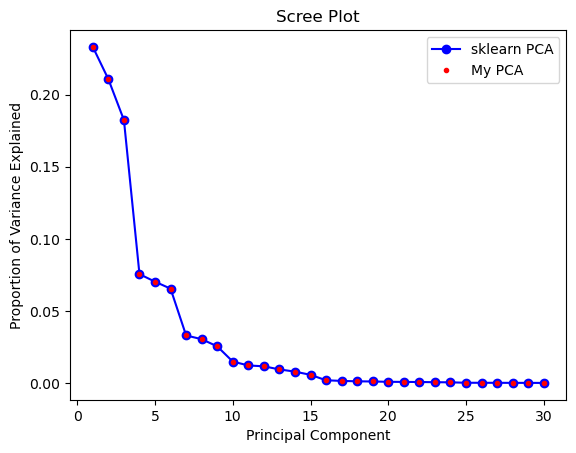

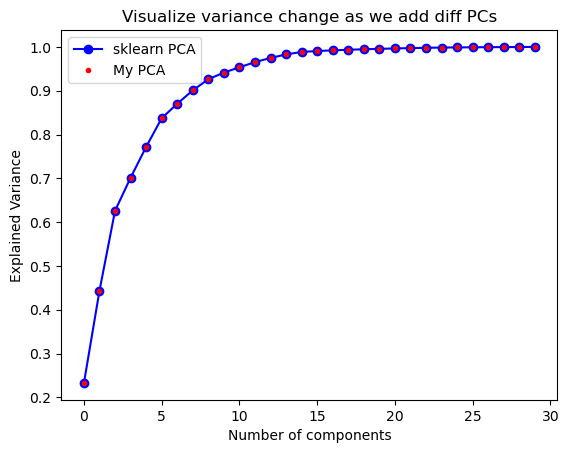

Proportion of variance explained by first 2 PCs = 0.4436008509069932


In [8]:
sklearn_PCA = PCA()
sklearn_PCA.fit(ca_og_pos)
ca_og_pca = sklearn_PCA.transform(ca_og_pos)

scree_plot(ca_og_eigvals, sklearn_PCA)

# 2. Perform PCA on modified coordinates

### The alignment was done using gromacs with the option "-fit rot+trans"

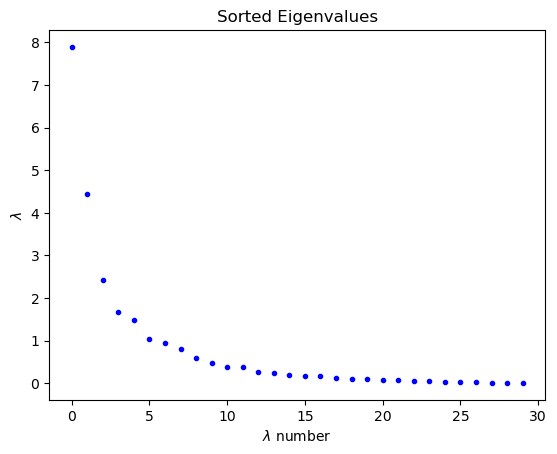

In [9]:
ca_rt_eigvals, ca_rt_projected, ca_rt_eigvecs = my_pca(ca_rt_pos,2)

### Comparing this to the eigenvalue spectrum for the original coordinates, here we see a much smoother spectrum, with a clearer gap. The first 2 PCs explain 44.36% of the total variance in the first case, whereas here it explains 50.80% of the total variance.

### In the first case, the first 3 PCs explain similar degrees of variance, and then there's a gap and then the next 3 PCs explain similar degrees of variance before a clear decrease.

### Here, the first PC is clearly the most dominant (and that is good for us since we want to visualize in 2D), and then the next PC is dominant over the rest and the explained variance falls off sharply after that.

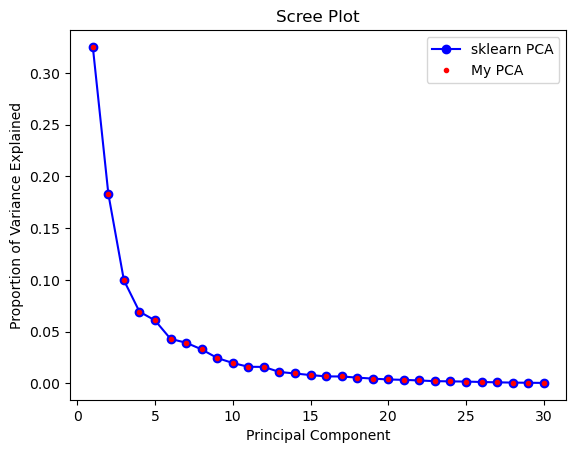

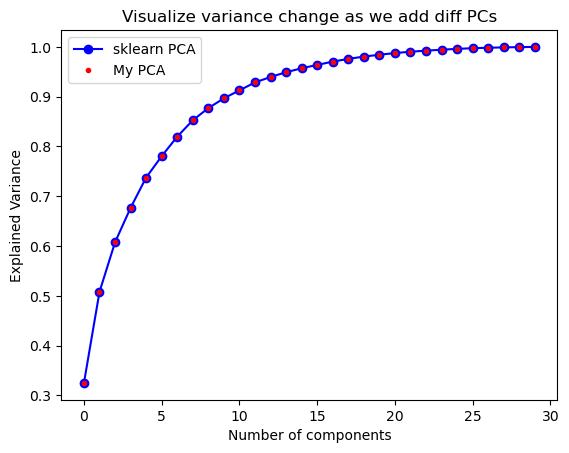

Proportion of variance explained by first 2 PCs = 0.5080587178636033


In [10]:
sklearn_PCA = PCA()
sklearn_PCA.fit(ca_rt_pos)
ca_rt_pca = sklearn_PCA.transform(ca_rt_pos)

scree_plot(ca_rt_eigvals, sklearn_PCA)

#### Plotting the configurations in the space of the first 2 PCs

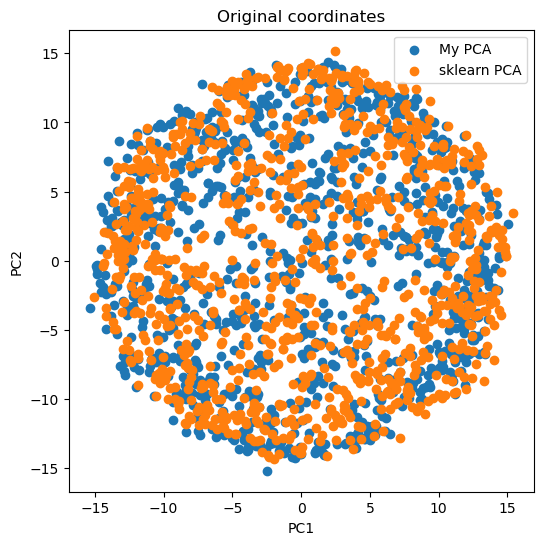

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(ca_og_projected[:,0],ca_og_projected[:,1],label='My PCA')
plt.scatter(ca_og_pca[:,0],ca_og_pca[:,1],label='sklearn PCA')
plt.title("Original coordinates")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

#print(ca_og_pca[:10,1])
#print(ca_og_projected[:10,1])

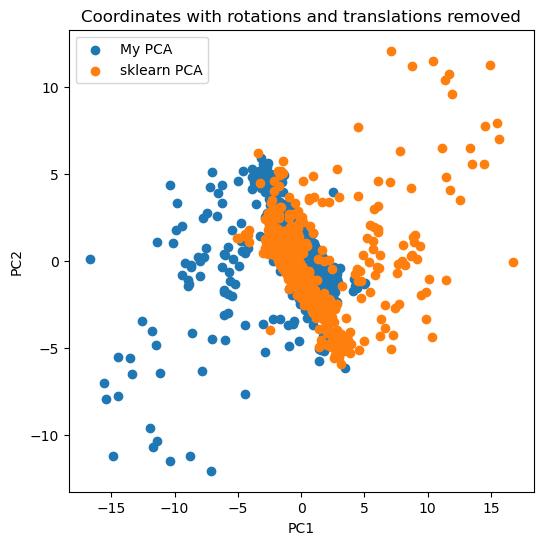

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_projected[:,0],ca_rt_projected[:,1],label='My PCA')
plt.scatter(ca_rt_pca[:,0],ca_rt_pca[:,1],label='sklearn PCA')
plt.title("Coordinates with rotations and translations removed")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

#print(ca_rt_pca[:10,1])
#print(ca_rt_projected[:10,1])

### Now let us visualize the trajectories. First we use MDAnalysis' own calculation of PCA and projection and then we verify the resultant movie against the one that we generate with our PCA.

In [13]:
test_pc = mda_pca.PCA(u_mod_rt,select="name CA",align=True,mean=None,n_components=None).run()
test_ca = u_mod_rt.select_atoms("name CA")
test_transformed = test_pc.transform(test_ca, n_components=3)

test_df = pd.DataFrame(test_transformed,
                  columns=['PC{}'.format(i+1) for i in range(3)])
test_df['Time (ps)'] = test_df.index * u_mod_rt.trajectory.dt
test_df.head()

#g = sb.PairGrid(test_df, hue='Time (ps)',
                 #palette=sb.color_palette('Oranges_d',
                 #                          n_colors=len(test_df)))
#g.map(plt.scatter, marker='.');


test_pc1 =  test_pc.p_components[:,0]
test_trans1 = test_transformed[:,0]
test_projected = np.outer(test_trans1,test_pc1) + test_pc.mean.flatten()

test_coords = test_projected.reshape(len(test_trans1), -1, 3)

test_proj1 = mda.Merge(test_ca)
test_proj1.load_new(test_coords, order="fac")

# plt.plot(test_pc.cumulated_variance[:10],'b.')
# plt.xlabel('Principal component')
# plt.ylabel('Cumulative variance')
# plt.show()

#view = nv.show_mdanalysis(test_proj1.atoms)
#view

view = nv.MDAnalysisTrajectory(test_proj1.atoms)
view_w = nv.NGLWidget(view)
view_w


NGLWidget(max_frame=999)

### Now, let us make our own movie for the coordinates where we removed rotations and translations.

        PC1       PC2  Time (ps)
0 -0.272739  0.995592        0.0
1  0.815994 -0.251542        1.0
2  0.379212  0.313041        2.0
3  0.307999  0.556560        3.0
4  1.082974  0.309560        4.0


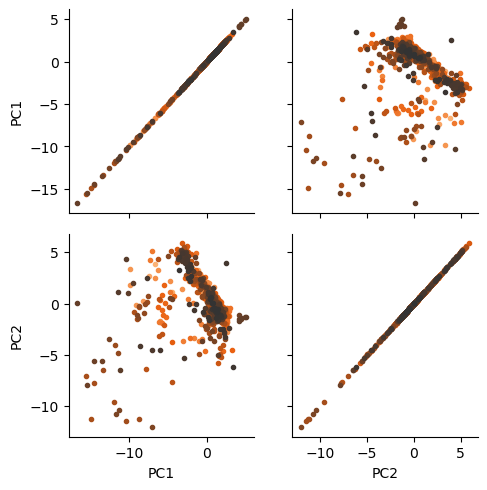

In [14]:
ca_rt_df = pd.DataFrame(ca_rt_projected,
                  columns=['PC{}'.format(i+1) for i in range(2)])
ca_rt_df['Time (ps)'] = ca_rt_df.index * u_mod_rt.trajectory.dt
print(ca_rt_df.head())

ca_rt_sb_plot = sb.PairGrid(ca_rt_df, hue='Time (ps)',
                 palette=sb.color_palette('Oranges_d',
                                           n_colors=len(ca_rt_df)))
ca_rt_sb_plot.map(plt.scatter, marker='.');

In [15]:
rt_proj = np.outer(ca_rt_projected[:,0], ca_rt_eigvecs[:,0]) + ca_rt_mean_pos.flatten()

rt_pc1_coords = rt_proj.reshape(len(ca_rt_projected[:,0]), -1, 3)

rt_proj_pc1 = mda.Merge(ca_rt)
rt_proj_pc1.load_new(rt_pc1_coords, order="fac") # fac -> order of data in array -> (f)rames, (a)toms, (c)oordinates

#view_rt = nv.show_mdanalysis(rt_proj_pc1.atoms)
#view_rt
view_rt = nv.MDAnalysisTrajectory(rt_proj_pc1.atoms)
view_rt_w = nv.NGLWidget(view_rt)
view_rt_w

NGLWidget(max_frame=999)

### As one can see, the behaviour is similar.

### The cell below writes this to a PDB file and we compare that trjaectory to the ones automatically calculated by gromacs (gmx covar and gmx anaeig).

### The gromacs generated movie in VMD shows much more clearly that the protein is unfolding along the first PC.

In [16]:
rt_proj_pc1.load_new(rt_pc1_coords,order='fac')

with mda.Writer("rt_pc1.pdb", rt_proj_pc1.atoms.n_atoms) as W:
    for ts in rt_proj_pc1.atoms.universe.trajectory:
        W.write(rt_proj_pc1.atoms)

# 3. MDS with dRMSD metric

### These first 2 cells are just testing and templating to generate an efficient way to calculate dRMSD.
### They were not removed for the sake of completeness.

In [17]:
# Testing drmsd

T=500   # Number of time-steps
N=10  # Number of atoms
dim=3 # Number of spatial dimensions of the atoms

np.random.seed(1721313)

## Creating the data

#X = [[np.random.randn(dim) for a in range(N)]for t in range(T)]
X = np.random.randint(1,10,size=(T*N*dim))

X =  np.array(X)
X = X.reshape(T,N,dim)
print(X.shape)

# Creating the distance matrix
d = [cdist(X[t],X[t], metric = 'euclidean')for t in range(T)]
d = np.array(d)
print(d.shape)

drmsd = [np.sqrt(((d[tA][np.triu_indices(N,1)]-d[tB][np.triu_indices(N,1)])**2).sum()/N)for tA in range(T) for tB in range(T)]
drmsd = np.array(drmsd)
drmsd = drmsd.reshape(T,T)
print(drmsd.shape)

d2 = d.reshape(T,-1)
print(d2.shape)

drmsd_2 = distance_matrix(d2,d2)
drmsd_2 = drmsd_2/(np.sqrt(2*N))
print(drmsd_2.shape)

np.max(np.abs(drmsd_2-drmsd))

(500, 10, 3)
(500, 10, 10)
(500, 500)
(500, 100)
(500, 500)


3.552713678800501e-15

In [18]:
X = X.reshape(T,-1)
#print(X.shape)
#print(drmsd)
#print(X)


I = np.identity(T)
Jn = np.ones((T,T))
Jn = Jn/T
C = I - Jn

#print(drmsd.shape)

# Double Centering -> G == B (in wikipedia) -> Gram Matrix
G = -(C @ drmsd @ C)/2
evg,evcg=np.linalg.eig(G)
#print(evg)
#print(G)


assert np.allclose(G, G.T, atol=1.0e-8)
assert np.allclose(np.abs(np.sum(G,axis=0)),0.0, atol=1.0e-08)
assert np.allclose(np.abs(np.sum(G,axis=1)),0.0, atol=1.0e-08)

sigma = 2.0
#print("KERNEL")
drmsd_transformed = np.exp(-drmsd/(2*(sigma**2)))
#print(drmsd_transformed)

kpca = [np.exp((-np.sqrt(((d[tA][np.triu_indices(N,1)]-d[tB][np.triu_indices(N,1)])**2).sum()/N))/(2*(sigma**2)))for tA in range(T) for tB in range(T)]
kpca = np.array(kpca)
kpca = kpca.reshape(T,T)
#print(kpca.shape)
#print(kpca)

assert np.abs(kpca-drmsd_transformed).all() < 1.0e-8

K = np.exp(-drmsd**2/(2*(sigma**2)))

#print("KPCA DIST MAT")
#print(K)
#print(K.shape)

G_K = (K - (Jn @ K) - (K @ Jn) + (Jn @ K @ Jn))

assert np.allclose(G_K, G_K.T, atol=1.0e-8)
assert np.allclose(np.abs(np.sum(G_K,axis=0)),0.0, atol=1.0e-08)
assert np.allclose(np.abs(np.sum(G_K,axis=1)),0.0, atol=1.0e-08)

#print(G_K)
#print(G_K.shape)
evgk,evcgk=np.linalg.eig(G_K)
#print(evgk)


### Now testing is over. Let the real code begin.

In [19]:
def drmsd(X):
    """
    Estimate the dRMSD from the trajectory. The formula is in the assignment.
    -----------------------------
    X: np.ndarray (2D) -> but it will be reshaped to a 3D array -> frames, atoms, coordinates
    """
    T = X.shape[0] # no. of timesteps
    X = X.reshape(T,-1,3) # 3 = no. of coordinates (X,Y,Z)
    
    #print(X.shape)

    _,N,_ = X.shape # no. of atoms

    # estimate the distance matrix between all sets of atoms for each timestep
    d = [cdist(X[t], X[t], metric = 'euclidean')for t in range(T)] 
    d = np.array(d)
    #print(d.shape)

    #drmsd_mat = [np.sqrt(((d[tA][np.triu_indices(N,1)] - d[tB][np.triu_indices(N,1)])**2).sum()/N)for tA in range(T) for tB in range(T)]
    #drmsd_mat = np.array(drmsd_mat)
    #drmsd_mat = drmsd_mat.reshape(T,T)
    #print(drmsd_mat.shape)

    # reshape the distance array from 3D to 2D since we only need timesteps and atomic distances can be flattened.
    d = d.reshape(T,-1)
    #print(d.shape)

    # estimate the drmsd distance matrix
    drmsd_mat = distance_matrix(d,d)

    # sqrt(2) since the i>j criteria is ignored and (1/2) comes inside sqrt
    # Also, sqrt(N) since N comes inside the sqrt
    drmsd_mat = drmsd_mat/(np.sqrt(2*N)) 

    #print(drmsd_mat.shape)

    return drmsd_mat    

In [20]:
def my_mds(X, num_components = 2):
    """
    Do MDS. Here the distance metric is the "dRMSD".
    --------------------------------------
    X: np.ndarray
    num_components: Number of components to project to. Default is set to 2.
    """

    T = X.shape[0] # number of data points <-> number of timesteps
    dist_matrix = np.zeros((T,T)) # delta_{i,j} from notes

    dist_matrix = drmsd(X) # call the drmsd() function


    # Double Centering -> G == B (in wikipedia: MDS algo section) -> Gram Matrix
    # Ref for formula: http://www.cs.umd.edu/~djacobs/CMSC828/MDSexplain.pdf (Pg. 2)
    # https://en.wikipedia.org/wiki/Multidimensional_scaling#Classical_multidimensional_scaling
    I = np.identity(T)
    Jn = np.ones((T,T))
    Jn = Jn/T
    C = I - Jn
    G = -(C @ dist_matrix @ C)/2

    # Verify properties of Gram Matrix
    assert np.allclose(G, G.T, atol=1.0e-8)
    assert np.allclose(np.abs(np.sum(G,axis=0)),0.0, atol=1.0e-08)
    assert np.allclose(np.abs(np.sum(G,axis=1)),0.0, atol=1.0e-08)

    eigvals, eigvecs = np.linalg.eig(G)

    # Sort the eigenvalues
    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]
    eigvals_reduced_dim = sorted_eigvals[0:num_components]

    # Create a diagonal matrix of eigenvalues (upto desired number of dimensions)
    eigval_mat = np.diag(eigvals_reduced_dim)

    # Sort the eigenvectors
    sorted_eigvecs = eigvecs[:,sorted_index]
    eigvec_reduced_dim = sorted_eigvecs[:,0:num_components]

    # Project X onto eigenvectors to obtain reduced dimensional representation
    X_projected = eigvec_reduced_dim @ np.sqrt(eigval_mat)
    #print(X_projected.shape)   

    # Make a plot for eigenvalues
    plt.plot(sorted_eigvals, 'b.')
    plt.title("Sorted Eigenvalues")
    plt.xlabel(r"$\lambda$ number")
    plt.ylabel(r"$\lambda$")
    
    #print(sorted_eigvals)

    return sorted_eigvals, X_projected

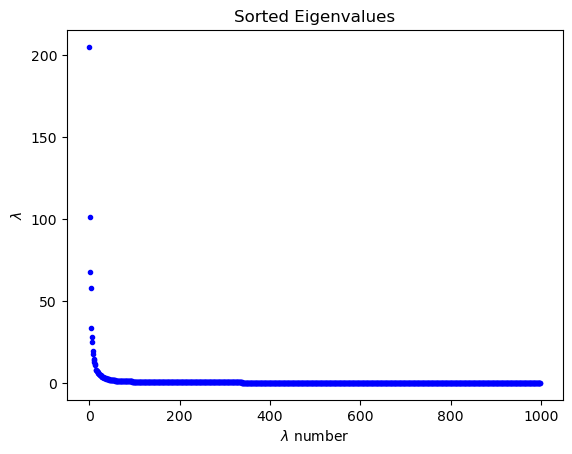

In [21]:
ca_rt_mds_eigvals, ca_rt_mds_projected = my_mds(ca_rt_pos)

In [22]:
def scree_plot_mds(eigvals, label_str='MDS'):
    
    variance_contributions = eigvals/np.sum(eigvals)

    PC_values = np.arange(variance_contributions.shape[0]) + 1
    plt.title('Scree Plot')
    plt.plot(PC_values, variance_contributions, 'r.', label=label_str)
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.legend()
    plt.show()

    plt.title('Visualize variance change as we add diff PCs')
    plt.ylabel('Explained Variance')
    plt.xlabel('Number of components')
    plt.plot(np.cumsum(variance_contributions), 'b.', label=label_str)
    plt.legend()
    plt.show()

    var_pc_1_2 = variance_contributions[0] + variance_contributions[1]
    print(f"Proportion of variance explained by first 2 PCs = {var_pc_1_2}")

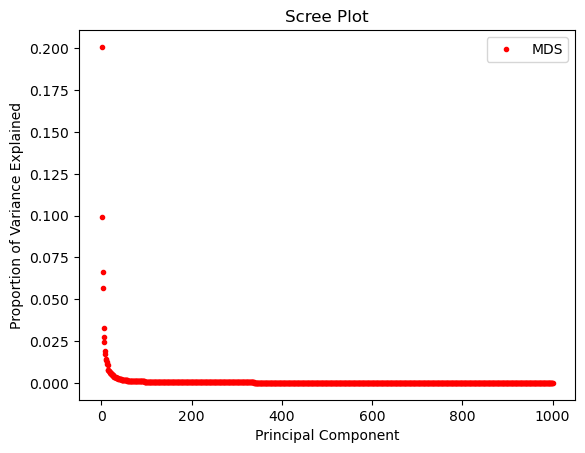

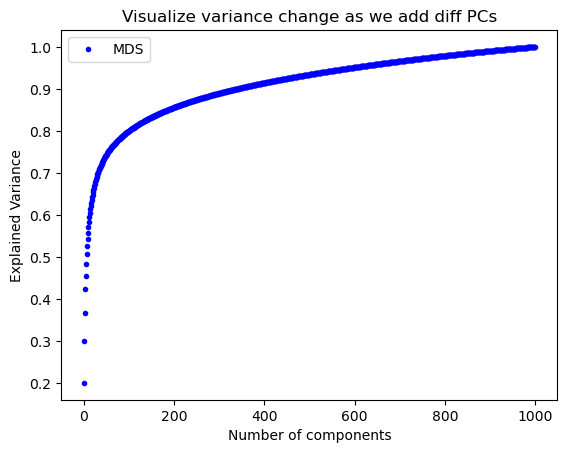

Proportion of variance explained by first 2 PCs = 0.2997775566324393


In [23]:
scree_plot_mds(ca_rt_mds_eigvals,label_str='MDS')

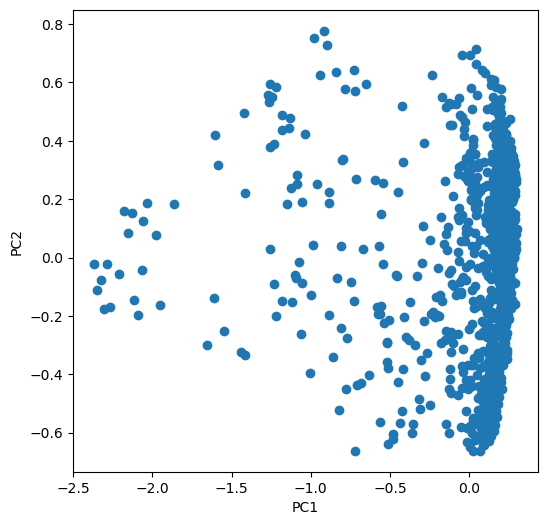

In [24]:
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_mds_projected[:,0],ca_rt_mds_projected[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#print(ca_rt_mds_projected[:10,1])
#print(ca_rt_mds_projected.shape)

        PC1       PC2  Time (ps)
0  0.008355  0.580545        0.0
1  0.158563  0.508198        1.0
2  0.186553  0.357460        2.0
3  0.166292  0.527544        3.0
4  0.211117 -0.110512        4.0


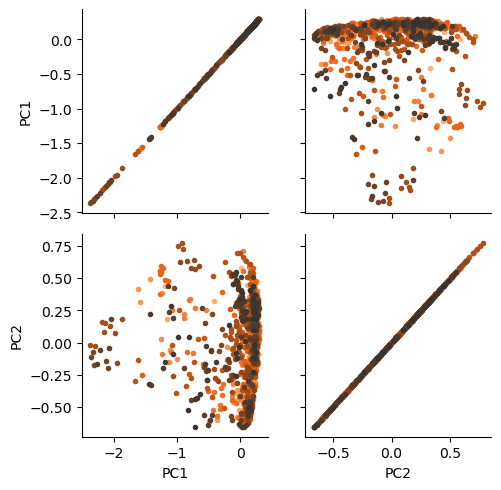

In [25]:
ca_rt_mds_df = pd.DataFrame(ca_rt_mds_projected,
                  columns=['PC{}'.format(i+1) for i in range(2)])
ca_rt_mds_df['Time (ps)'] = ca_rt_mds_df.index * u_mod_rt.trajectory.dt
print(ca_rt_mds_df.head())

ca_rt_mds_sb_plot = sb.PairGrid(ca_rt_mds_df, hue='Time (ps)',
                 palette=sb.color_palette('Oranges_d',
                                           n_colors=len(ca_rt_mds_df)))
ca_rt_mds_sb_plot.map(plt.scatter, marker='.');

# 4. Kernel Transformation of dRMSD

### For eg, K_tt’=exp(-dRMSD_t,t’/sigma)

In [26]:
def kernel_drmsd(X):
    """
    Estimate the dRMSD from the trajectory. The formula is in the assignment.
    A separate function is used in case one wants/needs to employ the kernel transformation of the distance directly here.
    For most cases, the my_kpca() calling function will do the transformation, but in the rare cases that one might need to perform the kernel transformation directly, this function is made modular for those scenarios.
    -----------------------------
    X: np.ndarray (2D) -> but it will be reshaped to a 3D array -> frames, atoms, coordinates
    """
    T = X.shape[0] # no. of timesteps
    X = X.reshape(T,-1,3) # 3 = no. of coordinates (X,Y,Z)
    
    #print(X.shape)

    _,N,_ = X.shape # no. of atoms

    # estimate the distance matrix between all sets of atoms for each timestep
    d = [cdist(X[t], X[t], metric = 'euclidean')for t in range(T)]
    d = np.array(d)
    #print(d.shape)

    # reshape the distance array from 3D to 2D since we only need timesteps and atomic distances can be flattened.
    d = d.reshape(T,-1)
    #print(d.shape)

    # estimate the drmsd distance matrix
    drmsd_mat = distance_matrix(d,d)

    # sqrt(2) since the i>j criteria is ignored and (1/2) comes inside sqrt
    # Also, sqrt(N) since N comes inside the sqrt
    drmsd_mat = drmsd_mat/(np.sqrt(2*N))
    #print(drmsd_mat.shape)
    
    ## This commented out section can be used to explicitly compute kernel transformations of dRMSD
    ## Also, the fancy, efficient dRMSD formula was verified against this slower but more explicit version to be correct using the 'assert' statement.
    
    #drmsd_1 = [np.sqrt(((d[tA][np.triu_indices(N,1)] - d[tB][np.triu_indices(N,1)])**2).sum()/N)for tA in range(T) for tB in range(T)]
    #drmsd_1 = np.array(drmsd_1)
    #drmsd_1 = drmsd_1.reshape(T,T)
    #print(drmsd_mat.shape)
    #assert (np.abs(drmsd_mat-drmsd_1)).all() < 1.0e-8

    return drmsd_mat

In [27]:
def my_kpca(X, gamma, c, kernel_type = 'gaussian', degree = 5, num_components = 2):
    """
    Do Kernel PCA. 
    Here the distance metric is the "dRMSD".
    Then we do a kernel transformation of dRMSD.
    The goal is to maximize variance captured by PC1 and PC2.
    ---------------------------------------------------------
    X: Numpy Array
    gamma: Usually a scaling factor for the dRMSD, for eg, d^2/gamma
    c: a constant scaling factor. 0 for the Gaussian kernel, but a free parameter for other ones.
    kernel_type: 'gaussian', 'tanh', 'polynomial'. Default is set to 'gaussian'.
    degree: Only used for the polynomial kernel. Default is set to 5.
    num_components: Number of components to project to. Default is set to 2.
    """

    T = X.shape[0] # number of data points <-> number of timesteps
    dist_matrix = np.zeros((T,T)) # delta_{i,j} from notes

    dist_matrix = kernel_drmsd(X) # call the kernel_drmsd() function

    # Do a kernel transformation of the distance
    # gamma = n_features is common choice (Ref: sklearn docs)
    if kernel_type == 'gaussian':
        c = 0
        K = 1 - np.exp(-(dist_matrix**2)/(gamma))
    elif kernel_type == 'tanh':
        K = np.tanh(((dist_matrix**2)/gamma)+c)
    elif kernel_type == 'polynomial':
        limit_val = np.power(np.max(np.abs(dist_matrix)),degree) # used to ensure values scale down and prevent negative eigenvalues
        #print(limit_val)
        coeffs = np.random.randint(int(limit_val)+1, int(10*limit_val), size=(degree)) # generate random coefficients
        coeffs= 1/coeffs # invert the coefficients
        #print(coeffs)
        p=np.poly1d(coeffs) # generate a polynomial with those coefficients
        K = p(((dist_matrix**2)/gamma)+c)

    # Double Centering -> G
    # Formula for double centering:
    # https://arxiv.org/pdf/1207.3538.pdf
    # https://sebastianraschka.com/Articles/2014_kernel_pca.html#implementing-the-rbf-kernel-pca-step-by-step
    # Same formula as in mds() function, just expanded explicitly
    # The -1/2 term from class (not in the refs) is kept for consistency
    Jn = np.ones((T,T))
    Jn = Jn/T
    G = -0.5*(K - (Jn @ K) - (K @ Jn) + (Jn @ K @ Jn))

    # Verify properties of Gram Matrix
    assert np.allclose(G, G.T, atol=1.0e-8)
    assert np.allclose(np.abs(np.sum(G,axis=0)), 0.0, atol=1.0e-08)
    assert np.allclose(np.abs(np.sum(G,axis=1)), 0.0, atol=1.0e-08)

    eigvals, eigvecs = np.linalg.eig(G)

    # Sort the eigenvalues
    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]
    eigvals_reduced_dim = sorted_eigvals[0:num_components]

    # Create a diagonal matrix of eigenvalues (upto desired number of dimensions)
    eigval_mat = np.diag(eigvals_reduced_dim)

    # Sort the eigenvectors
    sorted_eigvecs = eigvecs[:,sorted_index]
    eigvec_reduced_dim = sorted_eigvecs[:,0:num_components]

    # Project X onto eigenvectors to obtain reduced dimensional representation
    X_projected = eigvec_reduced_dim @ np.sqrt(eigval_mat)
    #print(X_projected.shape)   

    #print(np.max(dist_matrix))

    # Make a plot for eigenvalues
    plt.plot(sorted_eigvals, 'b.')
    plt.title("Sorted Eigenvalues")
    plt.xlabel(r"$\lambda$ number")
    plt.ylabel(r"$\lambda$")
    
    #print(sorted_eigvals)

    return sorted_eigvals, X_projected

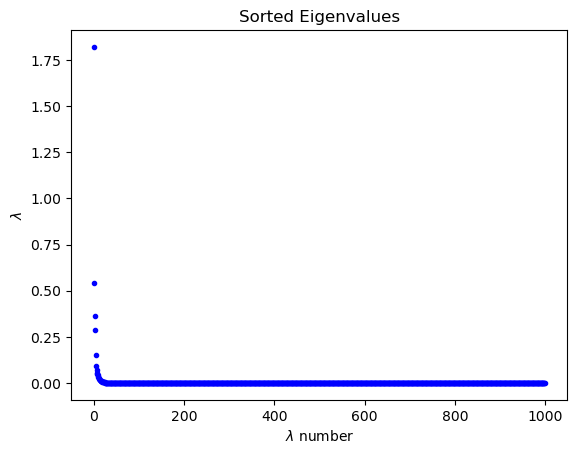

In [28]:
ca_rt_kpca_eigvals, ca_rt_kpca_projected = my_kpca(ca_rt_pos, gamma=1000, c=0, kernel_type='gaussian')

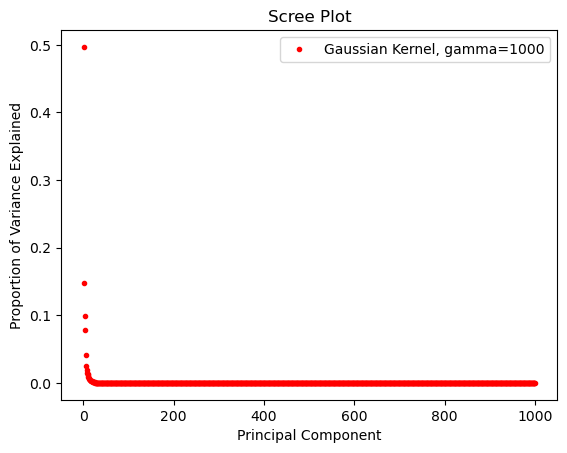

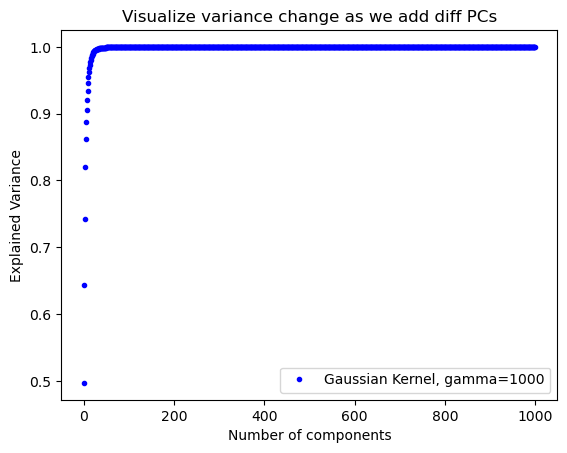

Proportion of variance explained by first 2 PCs = 0.6442049106564298


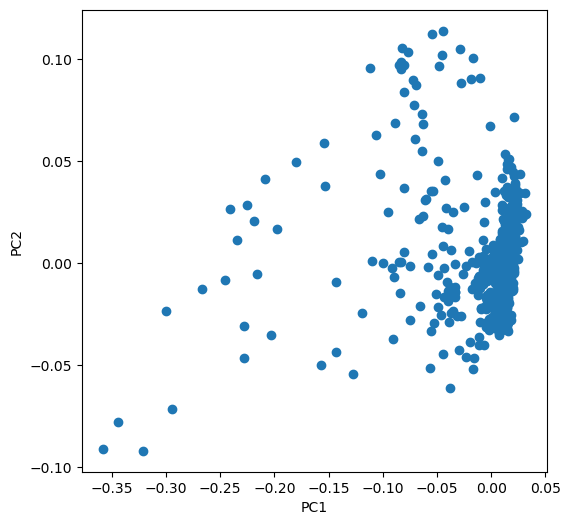

In [29]:
scree_plot_mds(ca_rt_kpca_eigvals,label_str='Gaussian Kernel, gamma=1000')
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_kpca_projected[:,0],ca_rt_kpca_projected[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

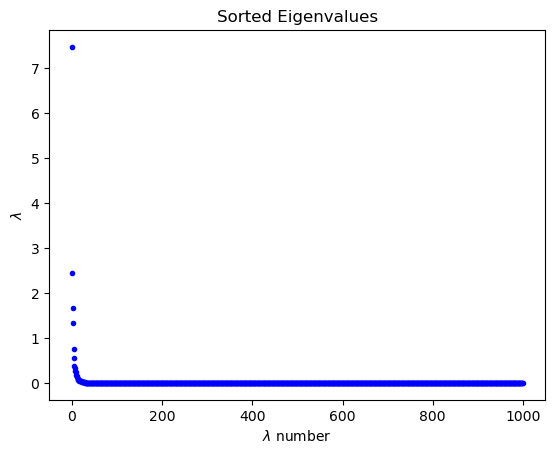

In [30]:
ca_rt_kpca_eigvals, ca_rt_kpca_projected = my_kpca(ca_rt_pos, gamma=200, c=0, kernel_type='gaussian')

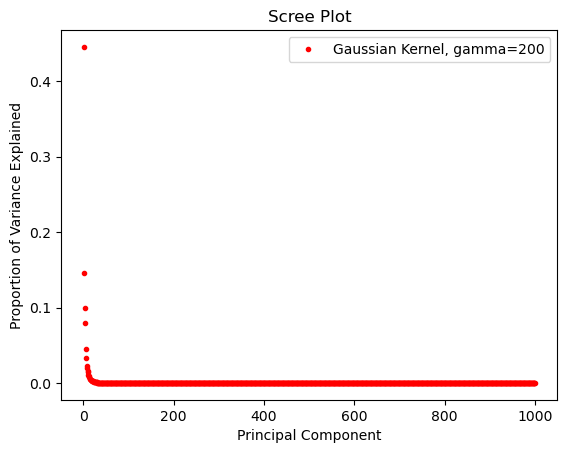

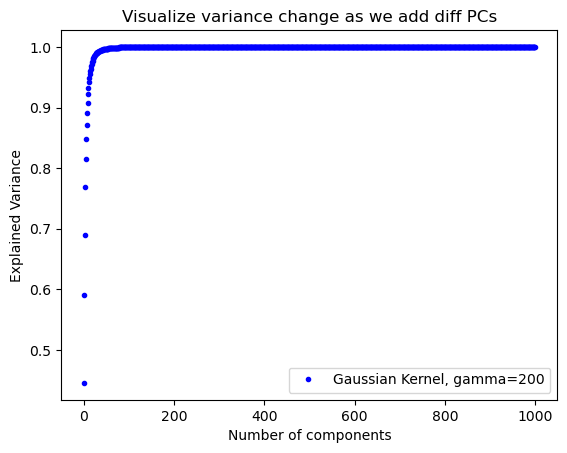

Proportion of variance explained by first 2 PCs = 0.5907861642293004


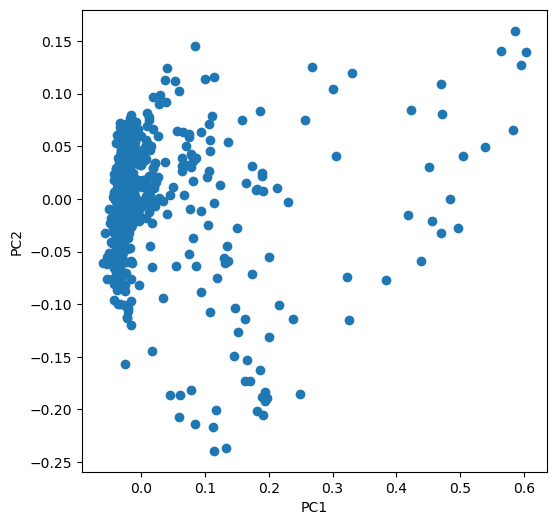

In [31]:
scree_plot_mds(ca_rt_kpca_eigvals,label_str='Gaussian Kernel, gamma=200')
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_kpca_projected[:,0],ca_rt_kpca_projected[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

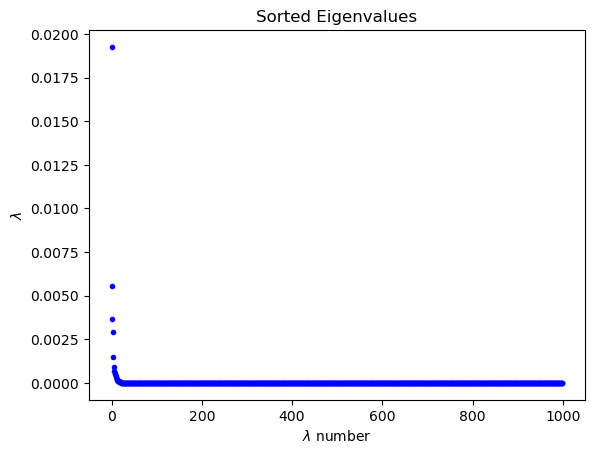

In [32]:
ca_rt_kpca_eigvals, ca_rt_kpca_projected = my_kpca(ca_rt_pos, gamma=100000, c=0, kernel_type='gaussian')

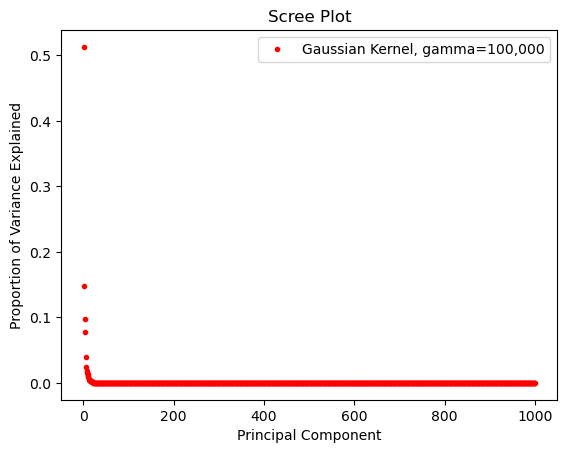

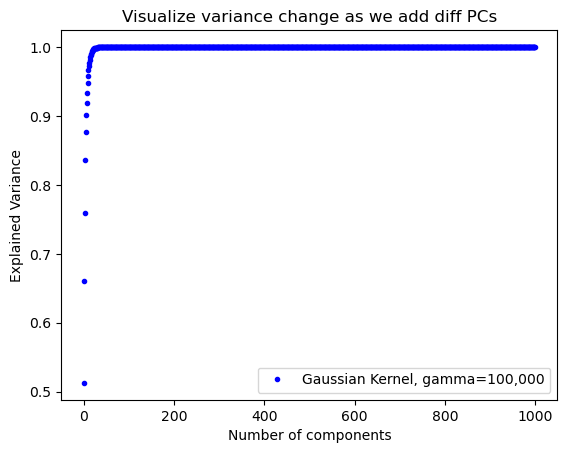

Proportion of variance explained by first 2 PCs = 0.6606532525077203


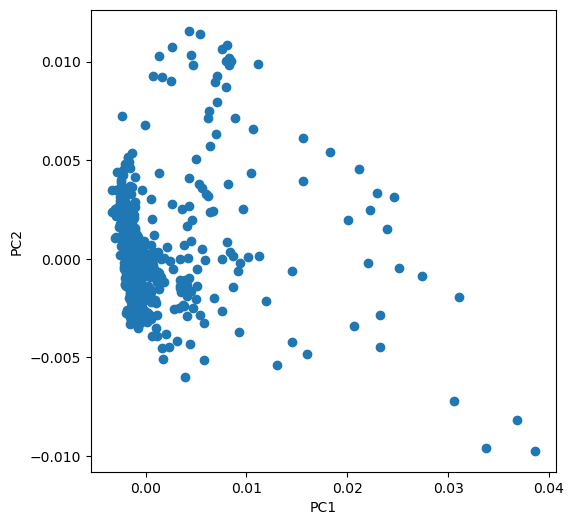

In [33]:
scree_plot_mds(ca_rt_kpca_eigvals,label_str='Gaussian Kernel, gamma=100,000')
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_kpca_projected[:,0],ca_rt_kpca_projected[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

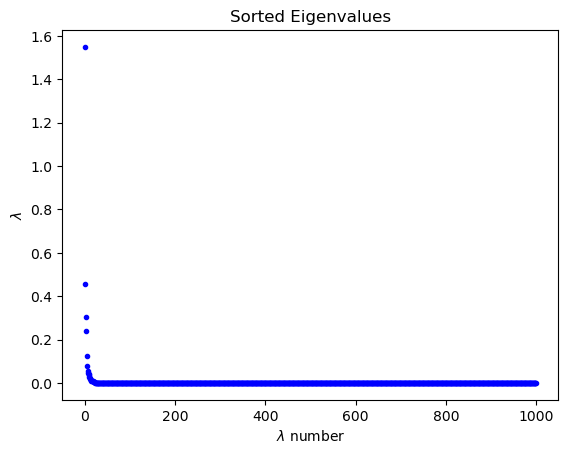

In [34]:
ca_rt_kpca_eigvals, ca_rt_kpca_projected = my_kpca(ca_rt_pos, gamma=1100, c=0.3, kernel_type='tanh')

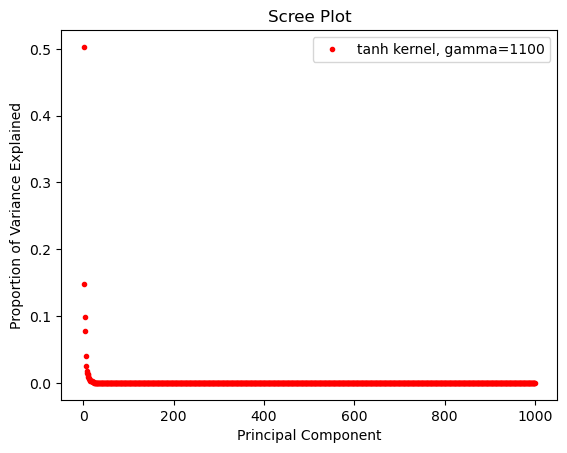

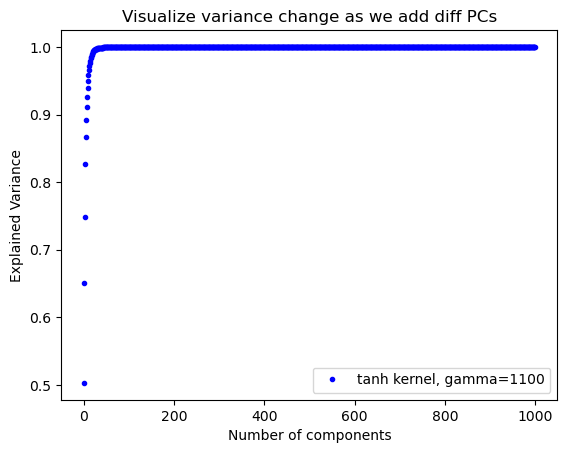

Proportion of variance explained by first 2 PCs = 0.6504391684234437


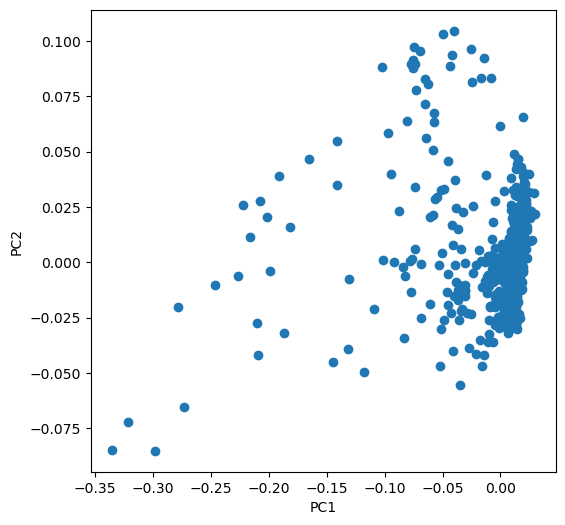

In [35]:
scree_plot_mds(ca_rt_kpca_eigvals, label_str='tanh kernel, gamma=1100')
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_kpca_projected[:,0],ca_rt_kpca_projected[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

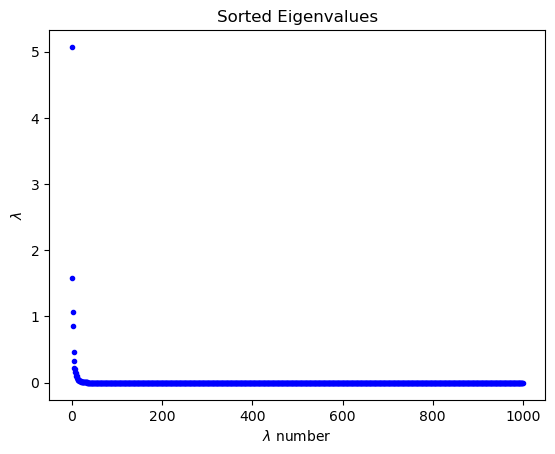

In [36]:
ca_rt_kpca_eigvals, ca_rt_kpca_projected = my_kpca(ca_rt_pos, gamma=300, c=0.3, kernel_type='tanh')

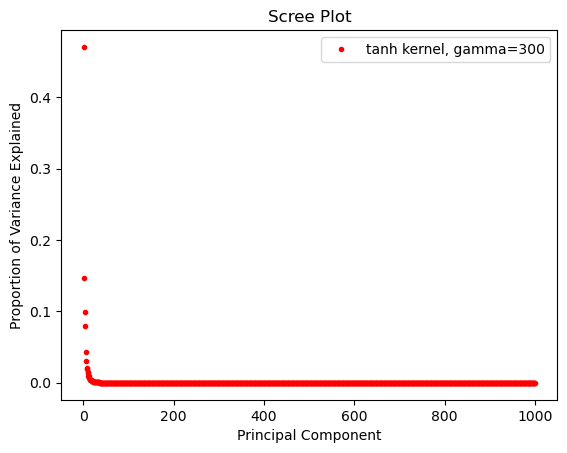

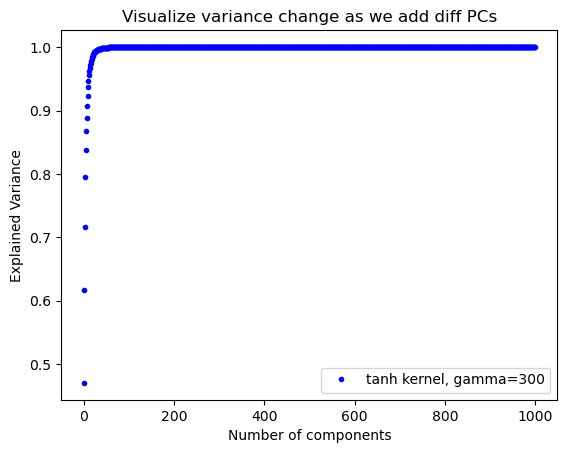

Proportion of variance explained by first 2 PCs = 0.6166011957832596


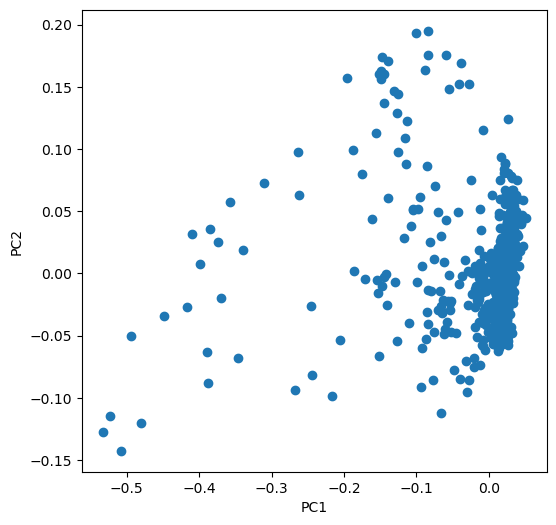

In [37]:
scree_plot_mds(ca_rt_kpca_eigvals, label_str='tanh kernel, gamma=300')
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_kpca_projected[:,0],ca_rt_kpca_projected[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

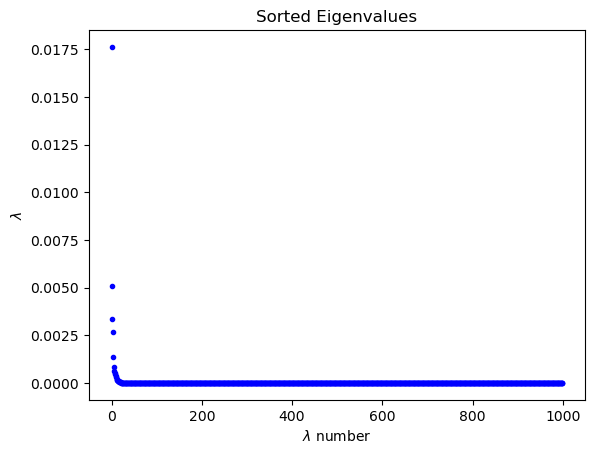

In [38]:
ca_rt_kpca_eigvals, ca_rt_kpca_projected = my_kpca(ca_rt_pos, gamma=100000, c=0.3, kernel_type='tanh')

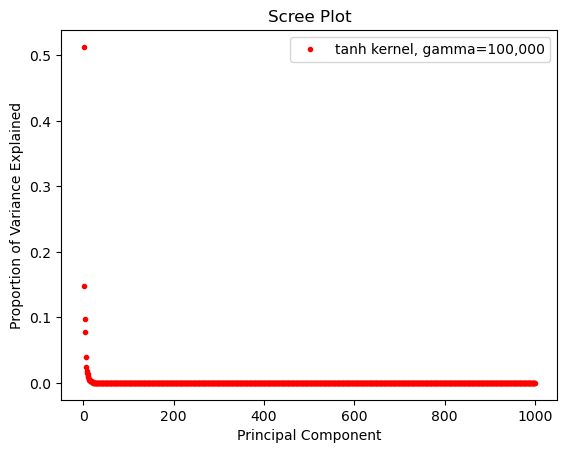

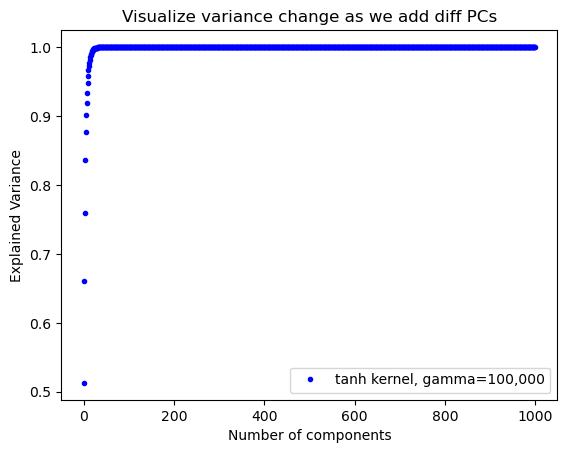

Proportion of variance explained by first 2 PCs = (0.66072562016833+3.701537892055523e-33j)


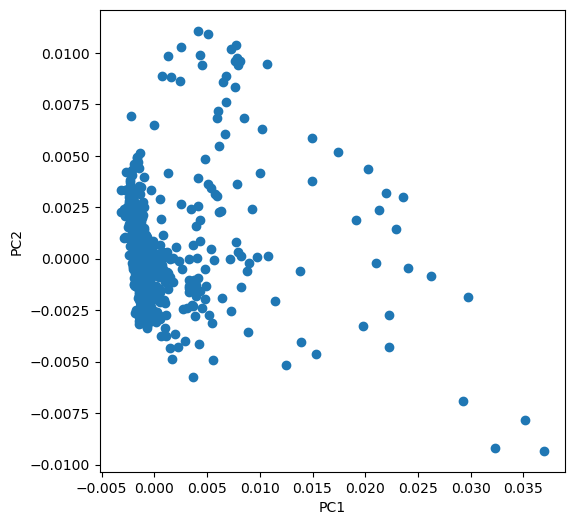

In [39]:
scree_plot_mds(ca_rt_kpca_eigvals, label_str='tanh kernel, gamma=100,000')
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_kpca_projected[:,0],ca_rt_kpca_projected[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

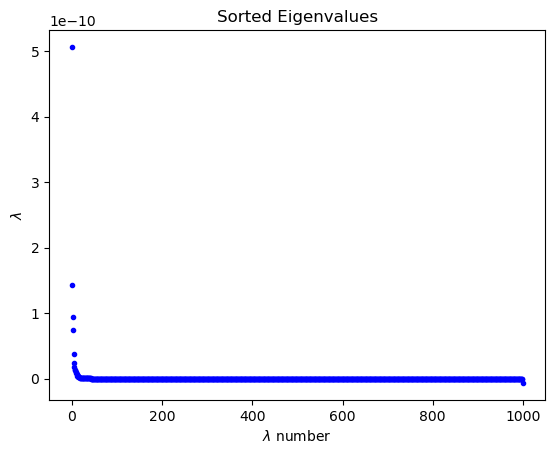

In [40]:
ca_rt_kpca_eigvals, ca_rt_kpca_projected = my_kpca(ca_rt_pos, gamma=2200, c=0.3, kernel_type='polynomial', degree=8)

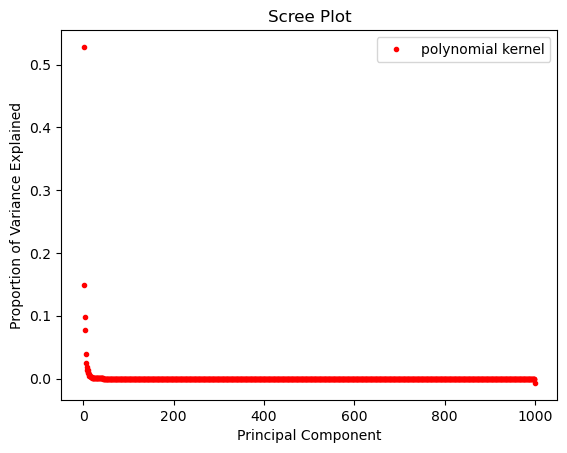

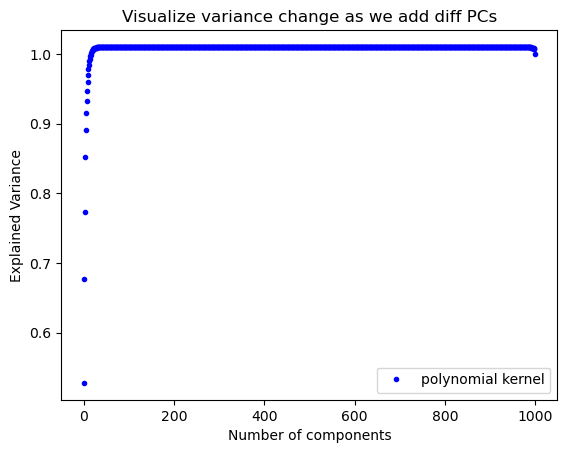

Proportion of variance explained by first 2 PCs = 0.6764307361183274


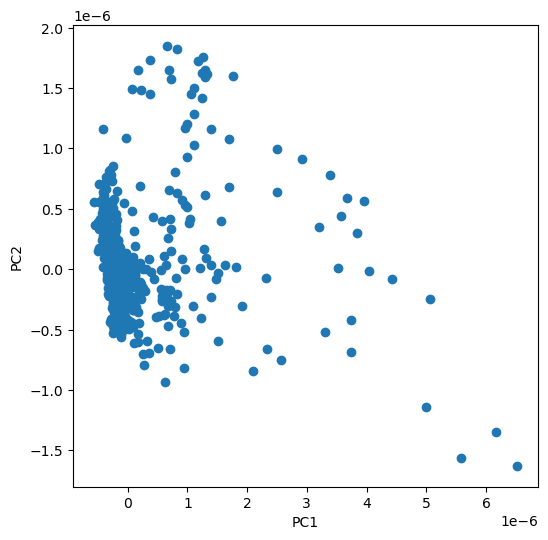

In [41]:
scree_plot_mds(ca_rt_kpca_eigvals, label_str='polynomial kernel')
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_kpca_projected[:,0],ca_rt_kpca_projected[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### The Gaussian and tanh kernels with high values of gamma (~1000) have about 64-65% of the total variance explained by the first 2 PCs.

### They perform a bit worse for lower values of gamma (~200-300) by explaining about 59-61% of the total variance in the first 2 PCs.

### But there is a law of diminishing returns, since even increasing gamma to 100K yields only 0.5-1.0% improvements (up to 66%). This is probably since distances get scaled down to very tiny values due to division by a large gamma.

### The polynomial kernel is a bit weird (probably a bug in my implementation). It also has an inherent degree of stochasticity since I let the coefficients of the polynomials be chosen randomly. But it tends to explain between 60-70% of the total variance in the first 2 PCs. However, these results should be treated with a grain (or maybe a bucket) of salt.